In [1]:
from __future__ import print_function

First we load the functions and libraries necessary for this report.

In [2]:
run analysis_functions.ipynb #import all helper functions

In [3]:
# Import main dataset
df = pd.read_csv('lastfm_9000_users.csv', na_filter=False)
df = df.drop(['Unnamed: 0'], axis=1)

The structure of the analysis will be as such: 
1. Objective
2. Prepare data
3. Model Fitting, Tuning, and Evaluation
    - Benchmarks
        - Most Popular
        - ALS Matrix Factorization
    - LightFM
        - Vanilla FM / BPR
        - FM with User/Item Side Information
        - Parameter Tuning
4. Model Exploration
    - Metrics Used (NDCG, Recall, Precision, Coverage)
    - Performance of each Model (Table)
    - NDCG Metric by User Type 
        - Active/Non-Active (Aggregate Plays)
        - Diverse/Non-Diverse (Top 1000 Artists)
        - "Basic"/Non-"Basic" (Popular)
    - Scale:
        - NDCG by Size
        - Training Time / Predict Time
6. Conclusion / Next Steps

# 0. Data Exploration

Let's see how the plays are distributed. 

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
sns.distplot(df.plays)

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [6]:
sns.distplot(df[df.plays < 1000].plays)

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [7]:
from sklearn.preprocessing import MinMaxScaler 

df['log_plays'] = df.plays.apply(lambda x: log(x))

df.log_plays *= (1.0/df.log_plays.max())

In [8]:
sns.distplot(df.log_plays)

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


# 1. Objective

BLALBALBALBLA

# 2. Prepare Data

### 2a. Create Sparse Matrix from Dataset

In [9]:
#create sparse matrix
plays_sparse = create_sparse_matrix(df).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

Creating sparse matrix...


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.8965986346416


### 2b. Split Data to Train/Test

Split data into train test set, maintaining that each user still has some interactions intact.

In [ ]:
# Split data into training and test sets
train, test, user_count = split_train_test_per_user(plays_sparse, 3, 10)
print("Percentage of original data masked:", pct_masked(plays_sparse, train.T.tocsr()))
print("Users masked:", user_count)

In [ ]:
#train is item by user to accomodate implicit and baseline training
train

#### Scaled Train/Test

In [ ]:
df_log = df.drop(columns = ['plays'], axis = 1)
# plays_sparse = create_sparse_matrix(df).astype('float')

In [ ]:
df_log.columns = ['user_id','artist_mbid','artist_name','plays']

In [ ]:
#create sparse matrix
plays_sparse_log = create_sparse_matrix(df_log).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_log))

# Split data into training and test sets
train_log, test_log, user_count_log = split_train_test_per_user(plays_sparse_log, 3, 10)
print("Percentage of original data masked:", pct_masked(plays_sparse_log, train_log.T.tocsr()))
print("Users masked:", user_count_log)

# 3. Model Fitting, Tuning, and Evaluation

- Note on evaluation: use metrics
- what autotune does

## 3a. Benchmarks

### Baseline

Baseline recommends the most-popular artists to everyone.

In [ ]:
model_baseline = Baseline(n_recs = 20)
model_baseline.fit(train)

No tuning is necessary since there are no parameters. We then evaluate the test set below: 

In [ ]:
coverage, precision, recall, ndcg = evaluate(model_baseline, "baseline", test, plays_sparse)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

### Model-Based (ALS)

Here we fit the model-based ALS Matrix Factorization using the implicit package from Homework 2 and use the parameters that were found to be optimized in the HW 2 report. 

In [ ]:
model_als = implicit.als.AlternatingLeastSquares(factors = 30, regularization = 0.01)

# Train model
print("Fitting model...")
model_als.fit(train)

In [ ]:
coverage, precision, recall, ndcg = evaluate(model_als, "implicit", test, train.T.tocsr())
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

### LightFM (without side information)

Here we fit the LightFM model.

In [ ]:
from lightfm import LightFM

model_fm_vanilla = LightFM(learning_rate = .05, loss='warp')

# Train Model
print("Fitting model...")
model_fm_vanilla.fit(train_log.T.tocsr(),user_features = None, item_features = None)


Now we try to find the best hyperparameter for this model and use the model with the best hyperparameter to get our results.

In [ ]:
#coverage, precision, recall, ndcg = evaluate(model_fm_vanilla, "lightfm", test, plays_sparse,liked=train.T.tocsr())
coverage, precision, recall, ndcg = evaluate(model_fm_vanilla, "lightfm", test_log, plays_sparse_log, liked = train_log)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

In [ ]:
# from lightfm.cross_validation import random_train_test_split
# from lightfm.evaluation import precision_at_k
# from lightfm.evaluation import recall_at_k

# train, test = random_train_test_split(plays_sparse_log)
# recall_at_k(model_fm_vanilla, test, k = 20).mean()

### LightFM (with side information)

In [ ]:
run artist_features.ipynb

In [ ]:
#insert side info here
user_features = None
item_features = None

model_fm_features = LightFM(no_components=30, loss='warp')

# Train Model
print("Fitting model...")
model_fm_features.fit(train.T.tocsr(),user_features, item_features)

Now we try to find the best hyperparameter for thi smodel with the best hyperparameter to get our results.

### Summary of Performance Results (Table)

# 4. Model Exploration

Next, we explore these models even more. How do they perform in regards to size, different user population?

## 4a. Performance by User Type

In [33]:
run grouping_functions.ipynb

### Active/Non-Active

In [21]:
import seaborn as sns

In [78]:
n=3
activity_groups=active_users(plays_sparse, n)
levels=[1,2,3]
ndcg_activity_als = []
recall_activity_als = []
precision_activity_als = []
coverage_activity_als = []

ndcg_activity_baseline = []
recall_activity_baseline = []
precision_activity_baseline = []
coverage_activity_baseline = []

for group in activity_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    print("Coverage:",coverage*100,'%')
    print("Precision:",precision*100,'%')

    recall_activity_baseline.append(recall)
    ndcg_activity_baseline.append(ndcg)
    precision_activity_baseline.append(precision)
    coverage_activity_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)
    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    print("Coverage:",coverage*100,'%')
    print("Precision:",precision*100,'%')

    recall_activity_als.append(recall)
    ndcg_activity_als.append(ndcg)
    precision_activity_als.append(precision)
    coverage_activity_als.append(coverage)


Fitting model...
Fitting baseline...
[6194. 1352. 3513. ...   28.   27.   24.]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:01,  9.12it/s]


Recall: 6.775956284153005 %
Average NDCG: 4.786805185772901 %
Coverage: 0.04246104199397053 %
Precision: 1.6939890710382512 %


100%|██████████| 15.0/15 [00:01<00:00,  8.08it/s]

Evaluating model...



Recall: 16.612021857923498 %
Average NDCG: 10.995741640367491 %
Coverage: 5.161139654367118 %
Precision: 4.1530054644808745 %



Fitting model...
Fitting baseline...
[37800.  6650. 11395. ...     0.     0.     0.]
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]


Recall: 6.980313646980314 %
Average NDCG: 4.854039254270085 %
Coverage: 0.04246104199397053 %
Precision: 1.7450784117450786 %


100%|██████████| 15.0/15 [00:02<00:00,  6.48it/s]

Evaluating model...



Recall: 17.31731731731732 %
Average NDCG: 12.098077565521345 %
Coverage: 6.250265381512462 %
Precision: 4.32932932932933 %



Fitting model...
Fitting baseline...
[230791.  23444.  45401. ...      0.      0.      0.]
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]


Recall: 7.636849132176235 %
Average NDCG: 5.261193931189853 %
Coverage: 0.04246104199397053 %
Precision: 1.9092122830440588 %


100%|██████████| 15.0/15 [00:02<00:00,  5.72it/s]

Evaluating model...



Recall: 16.79572763684913 %
Average NDCG: 10.91549543986731 %
Coverage: 6.946626470213579 %
Precision: 4.198931909212282 %


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


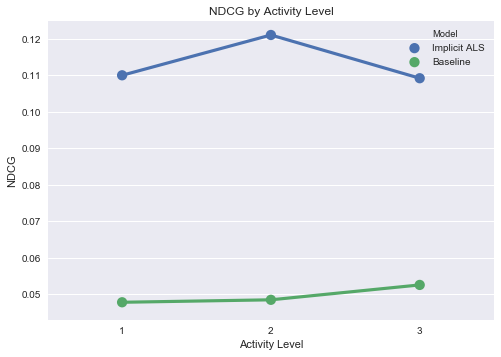

In [79]:
# Plot NDCG by Activity Level
ndcg_activity_als_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_activity_als})
ndcg_activity_baseline_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_activity_baseline})
f, ax = plt.subplots(1, 1)

ndcg_activity_als_df['Model'] = 'Implicit ALS'
ndcg_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([ndcg_activity_als_df,ndcg_activity_baseline_df])
sns.pointplot(ax=ax,x='N',y='NDCG',data=df,hue='Model')
plt.title('NDCG by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('NDCG')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


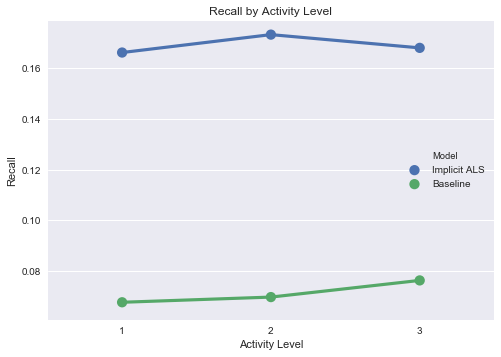

In [80]:
# Plot Recall by Activity Level
recall_activity_als_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_als})
recall_activity_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_baseline})
f, ax = plt.subplots(1, 1)

recall_activity_als_df['Model'] = 'Implicit ALS'
recall_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([recall_activity_als_df,recall_activity_baseline_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


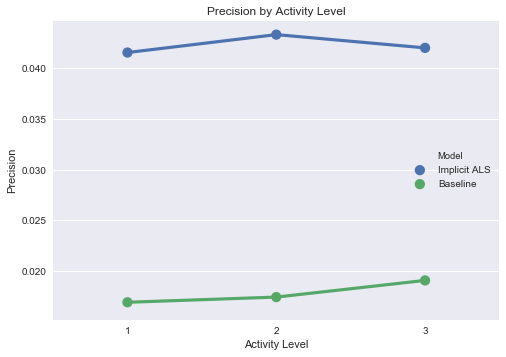

In [83]:
# Plot Precision by Activity Level
precision_activity_als_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_als})
precision_activity_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_baseline})
f, ax = plt.subplots(1, 1)

precision_activity_als_df['Model'] = 'Implicit ALS'
precision_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([precision_activity_als_df,precision_activity_baseline_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


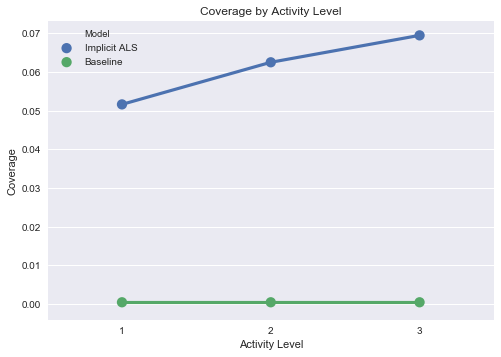

In [84]:
# Plot Coverage by Diversity Level
coverage_activity_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_als})
coverage_activity_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_baseline})
f, ax = plt.subplots(1, 1)

coverage_activity_als_df['Model'] = 'Implicit ALS'
coverage_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([coverage_activity_als_df,coverage_activity_baseline_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Coverage')

plt.show()

### Diverse/Non-Diverse

In [66]:
def old_evaluate(model, test, M, n_rec = 20):
    """
    Calculate precision/recall
    
    parameters:
    - model: fitted implicit model that will perform recommendations
    - test: list containing tuples that are heldout for each user
    - M: csr_matrix of item-users, used in fit
    - n_rec: how many recommendations the system outputs
    
    returns:
    - two numpy arrays containing precision and recall
    """
    #TODO: Refactor NDCG and Recall, less dependent on each other
    
    # Transpose matrix to use for implicit's recommend() function
    M_rec = M.T.tocsr() 
    
    tp = float(0)
    test_n = float(0)
    print('Evaluating model...')
    
    ndcg = list()
    
    # Calculate true positives for each user, append results to list
    for user, holdout_items in tqdm(test.items()):
        
        # Get list of item recs for each user
        rec = model.recommend(user, M_rec, N=n_rec, filter_already_liked_items=True) #returns (item_id, score)
        rec_items = [pair[0] for pair in rec] #get only item_id
        test_n += len(holdout_items) #total number of heldout items
        
        # For NDCG
        predicted_scores = zeros_list(n_rec)
        user_scores = zeros_list(n_rec)
        i = 0
            
        # Count true positives in recommended items
        for item in holdout_items: 
            value = M[user,item]
            user_scores[i] = value
            i += 1
            if item in rec_items:
                predicted_scores[rec_items.index(item)] = value #if holdout items is in recommended
                tp += 1
        # Calculate NDCG
        ndcg.append(ndcg_at_k(predicted_scores, user_scores))

    recall = tp/test_n
    return recall, np.mean(ndcg)

In [67]:
# Create a baseline model
def baseline(k,user_items):
    plays=user_items.toarray()
    totalplays=np.sum(plays,axis=1)    
    idx = (-totalplays).argsort()[:k]
    return idx

def old_evaluate_base(rec_items, test, M, n_rec = 20):
    """
    Calculate recall
    
    parameters:
    - model: fitted implicit model that will perform recommendations
    - test: list containing tuples that are heldout for each user
    - M: csr_matrix of item-users, used in fit
    - n_rec: how many recommendations the system outputs
    returns:
    - numpy array containing recall
    """
    # Transpose matrix to use for implicit's recommend() function
    M_rec = M.T.tocsr()
    
    tp = float(0)
    test_n = float(0)
    rec_items = list(rec_items)
    ndcg = list()

    print('Evaluating model...')
    # Calculate true positives for each user, append results to list

    for user, holdout_items in tqdm(test.items()):
        test_n += len(holdout_items)
        # Count true positives in recommended items
        predicted_scores = zeros_list(n_rec)
        user_scores = zeros_list(n_rec)
        i = 0
        for item in holdout_items:
            value = M[user,item]
            user_scores[i] = value
            i += 1
            if item in rec_items:
                predicted_scores[rec_items.index(item)] = value #if holdout items is in recommended
                tp += 1

        ndcg.append(ndcg_at_k(predicted_scores, user_scores))
        
    recall = tp/test_n
    return recall,np.mean(ndcg)

## Using old evaluate methods:


In [69]:
n=3
#diversity_groups=diverse_users(plays_sparse, n)
levels=[1,2,3]
ndcg_div_als = []
recall_div_als = []
precision_div_als = []
coverage_div_als = []

ndcg_div_baseline = []
recall_div_baseline = []
precision_div_baseline = []
coverage_div_baseline = []

for group in diversity_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    rec_items=baseline(20,group.T.tocsr())
    recall,ndcg = old_evaluate_base(rec_items,test,group)

    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')

    recall_div_baseline.append(recall)
    ndcg_div_baseline.append(ndcg)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    recall, ndcg = old_evaluate(model, test, group)
    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    recall_div_als.append(recall)
    ndcg_div_als.append(ndcg)


Fitting model...
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]


Recall: 7.211768730756073 %
Average NDCG: 4.5105459152320675 %


100%|██████████| 15.0/15 [00:02<00:00,  6.17it/s]


Evaluating model...



Recall: 16.058843653780364 %
Average NDCG: 10.768934016351055 %



Fitting model...
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:02,  6.84it/s]


Recall: 7.5050033355570385 %
Average NDCG: 5.2601828256953365 %


100%|██████████| 15.0/15 [00:02<00:00,  5.77it/s]


Evaluating model...



Recall: 16.184122748499 %
Average NDCG: 10.82374889846081 %



Fitting model...
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]


Recall: 6.3133333333333335 %
Average NDCG: 4.523840037032049 %


100%|██████████| 15.0/15 [00:02<00:00,  7.12it/s]

Evaluating model...



Recall: 16.68 %
Average NDCG: 10.835107879922608 %


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


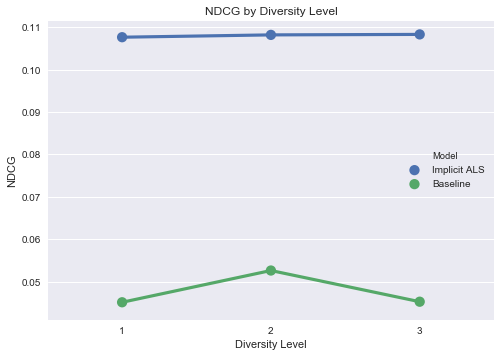

In [70]:
# Plot NDCG by Diversity Level
ndcg_div_als_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_div_als})
ndcg_div_baseline_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_div_baseline})
f, ax = plt.subplots(1, 1)

ndcg_div_als_df['Model'] = 'Implicit ALS'
ndcg_div_baseline_df['Model'] = 'Baseline'
df = pd.concat([ndcg_div_als_df,ndcg_div_baseline_df])
sns.pointplot(ax=ax,x='N',y='NDCG',data=df,hue='Model')
plt.title('NDCG by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('NDCG')

plt.show()

## Using new evaluate methods:

In [72]:
n=3
diversity_groups=diverse_users(plays_sparse, n)
levels=[1,2,3]
ndcg_div_als = []
recall_div_als = []
precision_div_als = []
coverage_div_als = []

ndcg_div_baseline = []
recall_div_baseline = []
precision_div_baseline = []
coverage_div_baseline = []

for group in diversity_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    print("Coverage:",coverage*100,'%')
    print("Precision:",precision*100,'%')

    recall_div_baseline.append(recall)
    ndcg_div_baseline.append(ndcg)
    precision_div_baseline.append(precision)
    coverage_div_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)
    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    print("Coverage:",coverage*100,'%')
    print("Precision:",precision*100,'%')

    recall_div_als.append(recall)
    ndcg_div_als.append(ndcg)
    precision_div_als.append(precision)
    coverage_div_als.append(coverage)


Fitting model...
Fitting baseline...
[1.04349e+05 9.22100e+03 1.56230e+04 ... 2.80000e+01 2.70000e+01
 2.40000e+01]
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]


Recall: 7.006500171057133 %
Average NDCG: 4.426799197570511 %
Coverage: 0.04246104199397053 %
Precision: 1.7516250427642832 %


100%|██████████| 15.0/15 [00:02<00:00,  5.45it/s]

Evaluating model...



Recall: 16.161477933629833 %
Average NDCG: 10.992684674944448 %
Coverage: 5.9318075665576835 %
Precision: 4.040369483407458 %



Fitting model...
Fitting baseline...
[92344.  8570. 26077. ...     0.     0.     0.]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:01,  7.14it/s]


Recall: 7.5050033355570385 %
Average NDCG: 5.2637730179707 %
Coverage: 0.04246104199397053 %
Precision: 1.8762508338892596 %


100%|██████████| 15.0/15 [00:01<00:00,  8.24it/s]

Evaluating model...



Recall: 16.110740493662444 %
Average NDCG: 10.65406927764402 %
Coverage: 5.8023013884760735 %
Precision: 4.027685123415611 %



Fitting model...
Fitting baseline...
[75484. 16468. 24400. ...     0.     0.     0.]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:02,  6.80it/s]


Recall: 6.3133333333333335 %
Average NDCG: 4.518626024119206 %
Coverage: 0.04246104199397053 %
Precision: 1.5783333333333334 %


100%|██████████| 15.0/15 [00:02<00:00,  7.92it/s]

Evaluating model...



Recall: 16.813333333333333 %
Average NDCG: 11.054940021194678 %
Coverage: 6.394632924291963 %
Precision: 4.203333333333333 %


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


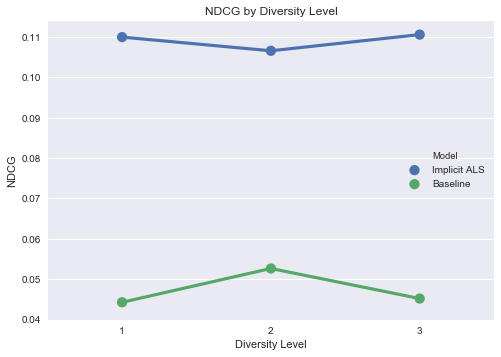

In [74]:
# Plot NDCG by Diversity Level
ndcg_div_als_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_div_als})
ndcg_div_baseline_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_div_baseline})
f, ax = plt.subplots(1, 1)

ndcg_div_als_df['Model'] = 'Implicit ALS'
ndcg_div_baseline_df['Model'] = 'Baseline'
df = pd.concat([ndcg_div_als_df,ndcg_div_baseline_df])
sns.pointplot(ax=ax,x='N',y='NDCG',data=df,hue='Model')
plt.title('NDCG by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('NDCG')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


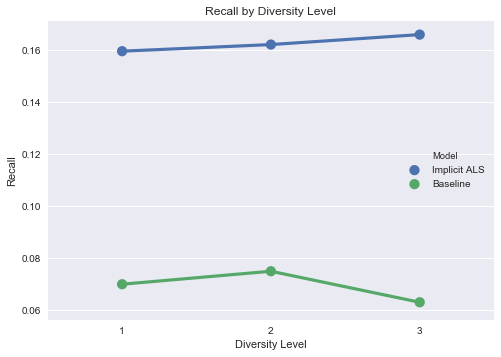

In [60]:
# Plot Recall by Diversity Level
recall_div_als_df = pd.DataFrame({'N':levels, 'Recall': recall_div_als})
recall_div_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_div_baseline})
f, ax = plt.subplots(1, 1)

recall_div_als_df['Model'] = 'Implicit ALS'
recall_div_baseline_df['Model'] = 'Baseline'
df = pd.concat([recall_div_als_df,recall_div_baseline_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


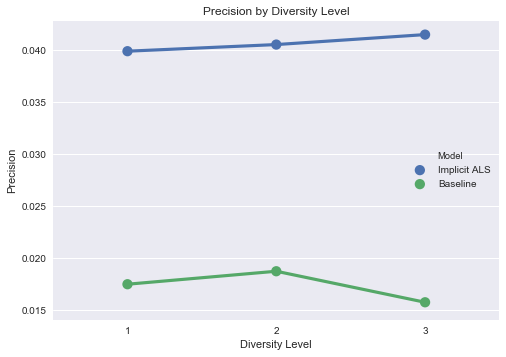

In [62]:
# Plot Precision by Diversity Level
precision_div_als_df = pd.DataFrame({'N':levels, 'Precision': precision_div_als})
precision_div_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_div_baseline})
f, ax = plt.subplots(1, 1)

precision_div_als_df['Model'] = 'Implicit ALS'
precision_div_baseline_df['Model'] = 'Baseline'
df = pd.concat([precision_div_als_df,precision_div_baseline_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


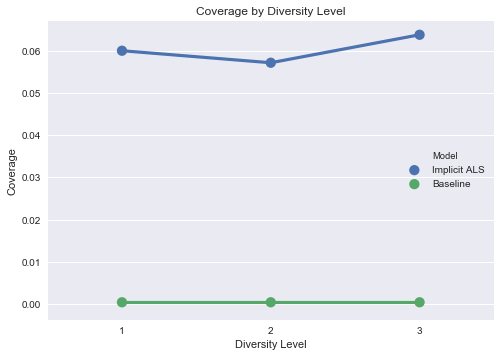

In [63]:
# Plot Coverage by Diversity Level
coverage_div_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_als})
coverage_div_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_baseline})
f, ax = plt.subplots(1, 1)

coverage_div_als_df['Model'] = 'Implicit ALS'
coverage_div_baseline_df['Model'] = 'Baseline'
df = pd.concat([coverage_div_als_df,coverage_div_baseline_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Coverage')

plt.show()

### Basic/Non-Basic

In [87]:
n=3
ms_groups=mainstream_users(plays_sparse, top_artists=20, n=3)
levels=[1,2,3]
ndcg_ms_als = []
recall_ms_als = []
precision_ms_als = []
coverage_ms_als = []

ndcg_ms_baseline = []
recall_ms_baseline = []
precision_ms_baseline = []
coverage_ms_baseline = []

for group in ms_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    print("Coverage:",coverage*100,'%')
    print("Precision:",precision*100,'%')

    recall_ms_baseline.append(recall)
    ndcg_ms_baseline.append(ndcg)
    precision_ms_baseline.append(precision)
    coverage_ms_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)
    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    print("Coverage:",coverage*100,'%')
    print("Precision:",precision*100,'%')

    recall_ms_als.append(recall)
    ndcg_ms_als.append(ndcg)
    precision_ms_als.append(precision)
    coverage_ms_als.append(coverage)


Fitting model...
Fitting baseline...
[ 7392.  9617. 19081. ...     0.     0.     0.]
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]

Recall: 2.46704967894559 %
Average NDCG: 1.1848020638967913 %
Coverage: 0.04246104199397053 %
Precision: 0.6167624197363974 %


100%|██████████| 15.0/15 [00:02<00:00,  7.68it/s]

Evaluating model...



Recall: 15.417370733355865 %
Average NDCG: 10.138706403826662 %
Coverage: 7.600526516920725 %
Precision: 3.8543426833389662 %



Fitting model...
Fitting baseline...
[3.7673e+04 1.2332e+04 1.7039e+04 ... 2.8000e+01 2.7000e+01 2.4000e+01]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:01,  7.23it/s]


Recall: 5.693135935397039 %
Average NDCG: 3.3300714657079413 %
Coverage: 0.04246104199397053 %
Precision: 1.4232839838492597 %


100%|██████████| 15.0/15 [00:01<00:00,  8.43it/s]

Evaluating model...



Recall: 15.0 %
Average NDCG: 10.01600382016395 %
Coverage: 5.961530295953462 %
Precision: 3.75 %



Fitting model...
Fitting baseline...
[271820.  12408.  31613. ...      0.      0.      0.]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:01,  7.54it/s]


Recall: 12.40133779264214 %
Average NDCG: 9.70676309374585 %
Coverage: 0.04246104199397053 %
Precision: 3.100334448160535 %


100%|██████████| 15.0/15 [00:02<00:00,  7.86it/s]

Evaluating model...



Recall: 17.270903010033443 %
Average NDCG: 10.589528010532689 %
Coverage: 4.110228865016348 %
Precision: 4.317725752508361 %


In [86]:
# Plot NDCG by Mainstreamness Level
ndcg_ms_als_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_ms_als})
ndcg_ms_baseline_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_ms_baseline})
f, ax = plt.subplots(1, 1)

ndcg_ms_als_df['Model'] = 'Implicit ALS'
ndcg_ms_baseline_df['Model'] = 'Baseline'
df = pd.concat([ndcg_ms_als_df,ndcg_ms_baseline_df])
sns.pointplot(ax=ax,x='N',y='NDCG',data=df,hue='Model')
plt.title('NDCG by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('NDCG')

plt.show()

ValueError: arrays must all be same length

In [ ]:
# Plot Recall by Mainstreamness Level
recall_ms_als_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_als})
recall_ms_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_baseline})
f, ax = plt.subplots(1, 1)

recall_ms_als_df['Model'] = 'Implicit ALS'
recall_ms_baseline_df['Model'] = 'Baseline'
df = pd.concat([recall_ms_als_df,recall_ms_baseline_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Recall')

plt.show()

In [ ]:
# Plot Precision by Mainstreamness Level
precision_ms_als_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_als})
precision_ms_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_baseline})
f, ax = plt.subplots(1, 1)

precision_ms_als_df['Model'] = 'Implicit ALS'
precision_ms_baseline_df['Model'] = 'Baseline'
df = pd.concat([precision_ms_als_df,precision_ms_baseline_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Precision')

plt.show()

In [ ]:
# Plot Coverage by Mainstreamness Level
coverage_ms_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_als})
coverage_ms_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_baseline})
f, ax = plt.subplots(1, 1)

coverage_ms_als_df['Model'] = 'Implicit ALS'
coverage_ms_baseline_df['Model'] = 'Baseline'
df = pd.concat([coverage_ms_als_df,coverage_ms_baseline_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Coverage')

plt.show()

## 4b. Performance by Input Size 

### Accuracy/NDCG

In [ ]:
size = [9000,20000,40000,60000,80000]
import time
train_time = list()
ndcg_size = []
recall_size = []
#get train data for each input size
for users in size:
    df = get_users(df_150, users)
    plays_sparse = create_sparse_matrix(df)

    # K-Nearest Neighbors
    model_fm_features = LightFM(no_components=30, loss='warp')
    
    start = time.time()
    # train model 
    print("Fitting model...")
    model_fm_features.fit(plays_sparse.T.tocsr(),user_features = None, item_features = None)    
    stop = time.time()
    total = stop-start
    train_time.append(total)
    coverage, precision, recall, ndcg = evaluate(model_fm_feature,"lightfm", test, plays_sparse)
    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    print("Coverage:",coverage*100,'%')
    print("Precision:",precision*100,'%')
    recall_size.append(recall)
    ndcg_size.append(ndcg)

#plot
df = pd.DataFrame({'n':size,'ndcg':ndcg_size})
sns.pointplot(x="n",y="ndcg",data=df)
plt.title('NDCG by Input Size for Factorization Machine')
plt.xlabel('Number of Users')
plt.ylabel('Time (s)')

### Training/Predict Time

In [ ]:
#plot LightFM training time vs input size
#plot
df = pd.DataFrame({'n':size,'time':train_time})
sns.pointplot(x="n",y="time",data=df)
plt.title('Training Time by Input Size for Factorization Machine')
plt.xlabel('Number of Users')
plt.ylabel('Time (s)')

# 5. Conclusion / Next Steps

# OLD STUFF: 

# Cross Validation and Parameter Tuning (k-fold)

In this section, we use k-fold cross validation to tune hyperparameters and evaluate our models.

### Splitting into test and training sets

In [ ]:
# Cross Validation test
k=5
train_list, test_list, user_count = split_train_test_per_user(plays_sparse,k,20,cross_valid=True)

## Evaluate and tune ALS

Tuning two parameters: number of latent factors and the regularization factor. 

For latent factors, we try values [10,20,30,40,50,60]

For regularization factors, we try [.01,.03,.05,.07]

In [ ]:
start = time.time()
model=implicit.als.AlternatingLeastSquares
ndcg_list,heatmap_list=auto_tune_parameter(4,20,model,plays_sparse,[10,20,30,40,50,60],[.01,.03,.05,.07],param3=None)
stop = time.time()
total = stop-start

In [ ]:
# Plot heatmap of parameter tuning results
sns.set_style("whitegrid")
sns.heatmap(heatmap_list[2], 
            xticklabels=['0.01','0.03','0.05','0.07'], 
            yticklabels=['10','20','30','40','50','60'], 
            cbar_kws={'label':'NDCG Score'})
plt.ylabel("Number of Latent Factors")
plt.xlabel("Regularization Factor")
plt.title("ALS NDCG scores according to Model Parameters")
plt.show()

Here we analyze the scalability of ALS by looking at datasets with 9k, 20k, 60k, and 150k users:

In [ ]:
# The following block imports larger datasets for scaling tests, these expanded CSVs are not available in the repo
files9k = pd.read_csv('lastfm_9000_users.csv', na_filter=False)
files20k = pd.read_csv('lastfm_20k_users.csv', na_filter=False)
files60k = pd.read_csv('lastfm_60k_users.csv', na_filter=False)
files150k = pd.read_csv('lastfm_150k_users.csv', na_filter=False)
files40k = get_users(files150k, 40000)
files = [files9k, files20k, files40k, files60k]

In [ ]:
# Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
size = [9000, 20000, 40000, 60000]
ndcg_size = []
recall_size = []
for i in files:
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)

    #create sparse matrix
    plays_sparse = create_sparse_matrix(i).astype('float')
    print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

    train, test, user_count = split_train_test_per_user(plays_sparse, 4, 20)

    # train model 
    print("Fitting model...")
    model.fit(train, show_progress=True)

    recall, ndcg = evaluate(model, test, plays_sparse)
    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    recall_size.append(recall)
    ndcg_size.append(ndcg)

In [ ]:
# Plot scalability of ALS model
ndcg_size_df = pd.DataFrame({'N':size,
                       'NDCG': ndcg_size})
g = sns.pointplot(x='N', y='NDCG', data=ndcg_size_df)
plt.title('NDCG by Input Size for ALS')
plt.xlabel('Number Of Users')
plt.show()

Here we analyze the catalog coverage of the ALS model:

In [ ]:
# Calculate catalog coverage of ALS model with optimal parameters
model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
model.fit(plays_sparse)
users = list(df.user_id.unique())
catalog = []
for i in range(0,len(users)):
    for x,y in model.recommend(i,plays_sparse.T.tocsr(), N=20, filter_already_liked_items=True):
        if x not in catalog:
            catalog.append(x)
print('Catalog Coverage is', len(catalog)/plays_sparse.shape[1])

# Tune ALS

Below we will tune the hyperparameters of ALS from a given range of hyperparameters.

In [ ]:
model=implicit.als.AlternatingLeastSquares
ndcg_list,heatmap_list=auto_tune_parameter(4,20,model,plays_sparse,[10,20,30,40,50,60],[.01,.03,.05,.07],param3=None)

sns.set_style("whitegrid")
sns.heatmap(heatmap_list[2], xticklabels=['0.01','0.03','0.05','0.07'], yticklabels=['10','20','30','40','50','60'], cbar_kws={'label':'NDCG Score'})
plt.ylabel("Number of Latent Factors")
plt.xlabel("Regularization Factor")
plt.title("ALS NDCG scores according to Model Parameters")
plt.show()

# Input Size vs Training Time

Below you can run the code using a larger dataset to evaluate performance tiem compared with input tiem

In [ ]:
#helper function to grab needed users
def get_users(df, n):
    sample_userid = df["user_id"].unique()
    sample_userid = np.random.choice(sample_userid, size = n, replace = False)

    #grab rows with sample user id
    df_sample = df[df.user_id.isin(sample_userid)].reset_index(drop = True)

    return df_sample

#in order to run this analysis, you need to download the 150k data at: 
#https://www.dropbox.com/s/qd8rnlxsuq0rjll/last_fm_bigger_data.zip?dl=0

#read in large dataset
df_150 = pd.read_csv('lastfm_150k_users.csv', na_filter=False)
df_150 = df_150.drop(['Unnamed: 0'], axis=1)

# ALS

In [ ]:
#plot ALS training time vs input size
#calculate training time for different input sizes for ALS
import sns
import time

size = [9000,20000,40000,60000,80000]
train_time = list()

#get train data for each input size
for users in size:
    df = get_users(df_150, users)
    plays_sparse = create_sparse_matrix(df)

    # K-Nearest Neighbors
    model = implicit.als.AlternatingLeastSquares(50)
    
    start = time.time()
    # train model 
    print("Fitting model...")
    model.fit(plays_sparse, show_progress=True)
    stop = time.time()
    total = stop-start
    train_time.append(total)

#plot
df = pd.DataFrame({'n':size,'time':train_time})
sns.pointplot(x="n",y="time",data=df)
plt.title('Training Time by Input Size for KNN')
plt.xlabel('Number of Users')
plt.ylabel('Time (s)')